## PRIPREMA I DATASET

#### PRIPREMA

In [8]:
# PROVJERA AKO NVDIA GPU VIDLJIV U OS-U
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 12 18:24:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060        Off | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P5              N/A / 115W |    745MiB /  8188MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
# INSTALACIJA POTREBNIH PAKETA
!pip install scikit-learn opencv-python pillow tensorflow==2.8.0 matplotlib gdown

In [10]:
# IMPORT POTREBNIH BIBLIOTEKA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import time
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
import pathlib
import cv2
import random
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [4]:
# PROVJERA AKO GPU MOŽE OBRAĐIVATI TENSORFLOW
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Jednostavan primjer množenja matrica
with tf.device('/GPU:0'):
    a = tf.constant([[2.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[2.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print("Result of matrix multiplication:\n", c)

# očekivani rezultat je:
# TensorFlow version: 2.8.0
# Num GPUs Available:  1

TensorFlow version: 2.8.0
Num GPUs Available:  1
Result of matrix multiplication:
 tf.Tensor(
[[4. 4.]
 [6. 7.]], shape=(2, 2), dtype=float32)


2024-06-10 18:29:35.903761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 18:29:36.006371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 18:29:36.006669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 18:29:36.009293: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
### RAZNE METODE KORIŠTENE U NOTEBOOKU

# PLOT GRAFOVA IZ HISTORY OBJEKTA
def plot_model_accuracy(history):
  loss_train = history.history['accuracy']
  loss_val = history.history['val_accuracy']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

def plot_model_loss(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(0,10)
  plt.legend()
  plt.show()

# CONFUSION MATRIX
def generate_report_and_matrix(model_path, X_val, y_val):
    best_model = models.load_model(model_path)
    loss, accuracy = best_model.evaluate(X_val, y_val)

    y_pred = best_model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_classes)

    # Classification Report
    class_report = classification_report(y_val, y_pred_classes, target_names=[str(i) for i in range(10)])

    print("Classification Report:\n")
    print(class_report)
    
    return conf_matrix

def plot_confusion_matrix(conf_matrix, club_names):
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=club_names, yticklabels=club_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# BAR PLOT PREDIKCIJA PO KLUBOVIMA
def plot_predictions(y_test, y_pred_classes, club_names):
    correct = (y_test == y_pred_classes)
    correct = correct.astype(int)

    correct_dict = {club: [0, 0] for club in club_names}

    for i in range(len(y_test)):
        if correct[i] == 1:
            correct_dict[club_names[y_test[i]]][0] += 1
        else:
            correct_dict[club_names[y_test[i]]][1] += 1

    correct_df = pd.DataFrame(correct_dict).T
    correct_df.columns = ['Točno', 'Netočno']
    correct_df = correct_df.sort_values(by='Točno')

    correct_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Prekdikcije po klubovima')
    plt.xlabel('Klub')
    plt.ylabel('Broj predikcija')
    plt.show()

# PRINTANJE TRAINING REZULTATA ZA MODELE
def print_training_results(history, start_time, end_time):
    duration = end_time - start_time
    print(f"Training duration: {round(duration, 4)} seconds")
    
    # Print the final training loss and accuracy
    print(f"Final training accuracy: {round(history.history['accuracy'][-1], 4)}")
    print(f"Final validation accuracy: {round(history.history['val_accuracy'][-1], 4)}")
    
    # Print the final validation loss and accuracy
    print(f"Final training loss: {round(history.history['loss'][-1], 4)}")
    print(f"Final validation loss: {round(history.history['val_loss'][-1], 4)}")

In [11]:
# PREGLED SLIKA
def plot_image(X,y ,index):
    plt.figure(figsize = (10,10))
    plt.imshow(X[index])
    plt.xlabel(y[index])

def list_and_open_image(data_dir_path, club_name, image_index):
    data_dir = pathlib.Path(data_dir_path)
    club_images = list(data_dir.glob(f'{club_name}/*'))
    print(club_images[:5])
    image = Image.open(str(club_images[image_index]))
    image.show()

# PLOT SLIKE - RANDOM SLIKA
def plot_images(combined_dict):
    fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    for i, (club_name, club_info) in enumerate(combined_dict.items()):
        random_index = random.randint(0, 1399) # odaberi random sliku
        img = cv2.imread(str(club_info['images'][random_index]))
        resized_img = cv2.resize(img, (128, 128))
        ax[i//5, i%5].imshow(resized_img)
        ax[i//5, i%5].set_title(club_name, fontdict={'fontsize': 12, 'font': 'monospace'})
        ax[i//5, i%5].axis('off')
    plt.show()

# PROVJERA VELIČINE SLIKE - RANDOM SLIKA
def image_size_check(combined_dict):
    random_label = random.choice(list(combined_dict.keys()))
    random_index = random.randint(0, len(combined_dict[random_label]['images']) - 1)
    img = cv2.imread(str(combined_dict[random_label]['images'][random_index]))
    return img.shape

#### DATASET

##### AKO DATASET NE POSTOJI LOKALNO POKRENUTI DOWNLOAD SA GOOGLE DRIVE-A I UNZIP

In [3]:
#https://drive.google.com/file/d/1b1o309UBeFFJRim-P2QIhckIAU5MBoVF/view?usp=sharing
import gdown

file_id = '1b1o309UBeFFJRim-P2QIhckIAU5MBoVF'
destination = 'nndl_resource_files.zip'

gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1b1o309UBeFFJRim-P2QIhckIAU5MBoVF
From (redirected): https://drive.google.com/uc?export=download&id=1b1o309UBeFFJRim-P2QIhckIAU5MBoVF&confirm=t&uuid=b1850886-b269-4a7f-a961-2154d515cbda
To: /home/vanja/nndl_project/nndl_resource_files.zip
100%|██████████| 522M/522M [00:49<00:00, 10.6MB/s] 


'nndl_resource_files.zip'

In [6]:
!unzip -o nndl_resource_files.zip

Archive:  nndl_resource_files.zip
   creating: dataset_64/
  inflating: dataset_64/resize.sh    
   creating: dataset_64/training/
   creating: dataset_64/training/dinamo/
  inflating: dataset_64/training/dinamo/dinamo_0001.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0002.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0003.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0004.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0005.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0007.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0008.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0010.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0011.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0012.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0013.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0014.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0015.jpg  
  inflating: dataset_64/training/dinamo/dinamo_0018.jpg  
  inflating: dat

#### PRIPREMA PODATAKA

In [13]:
# LISTANJE DATOTEKA
data_dir = 'dataset_64/training'
data_dir = pathlib.Path(data_dir)

In [14]:
# DICT SA KLUBOVIMA I LABELAMA
klubovi_dict = {
    'dinamo': {'images': list(data_dir.glob('dinamo/*')), 'label': 0},
    'gorica': {'images': list(data_dir.glob('gorica/*')), 'label': 1},
    'hajduk': {'images': list(data_dir.glob('hajduk/*')), 'label': 2},
    'istra': {'images': list(data_dir.glob('istra/*')), 'label': 3},
    'lokomotiva': {'images': list(data_dir.glob('lokomotiva/*')), 'label': 4},
    'osijek': {'images': list(data_dir.glob('osijek/*')), 'label': 5},
    'rijeka': {'images': list(data_dir.glob('rijeka/*')), 'label': 6},
    'rudes': {'images': list(data_dir.glob('rudes/*')), 'label': 7},
    'slaven': {'images': list(data_dir.glob('slaven/*')), 'label': 8},
    'varazdin': {'images': list(data_dir.glob('varazdin/*')), 'label': 9},
}

In [15]:
# LISTAJ UKUPNI BROJ SLICICA
br_slicica = len(list(data_dir.glob('*/*.jpg')))
klubovi = [str(klub).split('/')[-1] for klub in klubovi_dict.keys()]
print(f'{klubovi},\n Ukupni broj slicica: {br_slicica}')

['dinamo', 'gorica', 'hajduk', 'istra', 'lokomotiva', 'osijek', 'rijeka', 'rudes', 'slaven', 'varazdin'],
 Ukupni broj slicica: 14000


In [16]:
# IZLISTAJ BROJ SLICICA PO KLUBU
for ime, info in klubovi_dict.items():
    print(f"{ime}: {len(info['images'])} slicica")

dinamo: 1400 slicica
gorica: 1400 slicica
hajduk: 1400 slicica
istra: 1400 slicica
lokomotiva: 1400 slicica
osijek: 1400 slicica
rijeka: 1400 slicica
rudes: 1400 slicica
slaven: 1400 slicica
varazdin: 1400 slicica


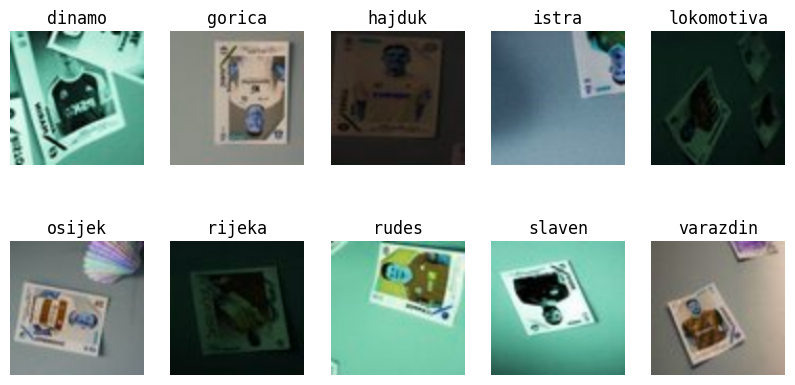

In [21]:
# PREGLED SLIKA IZ DATASETA
plot_images(klubovi_dict)

In [22]:
# PROVJERA VELIČINE SLIKE
image_size_check(klubovi_dict)

(64, 64, 3)

In [13]:
# PREBACI SLIKE U LISTU
# BROJ KLASA
num_classes = 10
#X - slike, y - labele

X, y = [], []

for klub_name, klub_info in klubovi_dict.items():
    for image in klub_info['images']:
        img = cv2.imread(str(image))
        if img is not None:
            X.append(img)
            y.append(klubovi_dict[klub_name]['label'])
        else:
            print(f"Image at {image} could not be read.")

In [14]:
# PROVJERI VELIČINU SLIKA NAKON KONVERZIJE
print(f"X shape: {X[0].shape}\ny shape: {len(y)}")

X shape: (64, 64, 3)
y shape: 14000


In [15]:
# PREACI U NUMPY ARRAY
X = np.array(X)
y = np.array(y)

In [16]:
#TRAIN TEST SPLIT  (train 80% test 20%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
# NORMALIZACIJA SLIKA
X_train = X_train / 255
X_val = X_val / 255

## MODELI

### ALPHA

In [19]:
model = models.Sequential(name="AlphaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "AlphaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4

In [20]:
start_time = time.time()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='sgd', loss=loss_fn, metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.25, callbacks=[callback])
end_time = time.time()

Epoch 1/50


2024-06-10 17:06:05.084841: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700


263/263 [==============================] - 2s 4ms/step - loss: 2.2711 - accuracy: 0.1563 - val_loss: 2.2608 - val_accuracy: 0.1689
Epoch 2/50
263/263 [==============================] - 1s 4ms/step - loss: 2.1989 - accuracy: 0.2065 - val_loss: 2.4039 - val_accuracy: 0.1104
Epoch 3/50
263/263 [==============================] - 1s 5ms/step - loss: 2.1267 - accuracy: 0.2402 - val_loss: 2.1121 - val_accuracy: 0.2739
Epoch 4/50
263/263 [==============================] - 1s 5ms/step - loss: 2.0575 - accuracy: 0.2768 - val_loss: 2.0626 - val_accuracy: 0.2621
Epoch 5/50
263/263 [==============================] - 1s 4ms/step - loss: 1.9904 - accuracy: 0.3077 - val_loss: 1.9987 - val_accuracy: 0.2989
Epoch 6/50
263/263 [==============================] - 1s 4ms/step - loss: 1.9200 - accuracy: 0.3371 - val_loss: 1.9478 - val_accuracy: 0.3296
Epoch 7/50
263/263 [==============================] - 1s 5ms/step - loss: 1.8502 - accuracy: 0.3632 - val_loss: 1.9352 - val_accuracy: 0.3168
Epoch 8/50
263/26

In [21]:
print_training_results(history, start_time, end_time)

Training duration: 59.2802 seconds
Final training accuracy: 1.0
Final validation accuracy: 0.815
Final training loss: 0.0055
Final validation loss: 1.0023


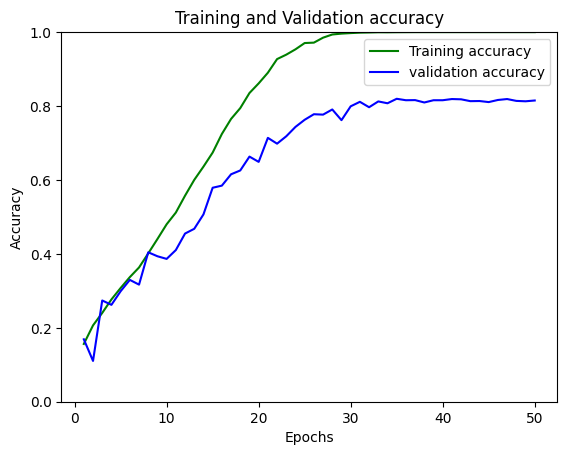

In [22]:
plot_model_accuracy(history)

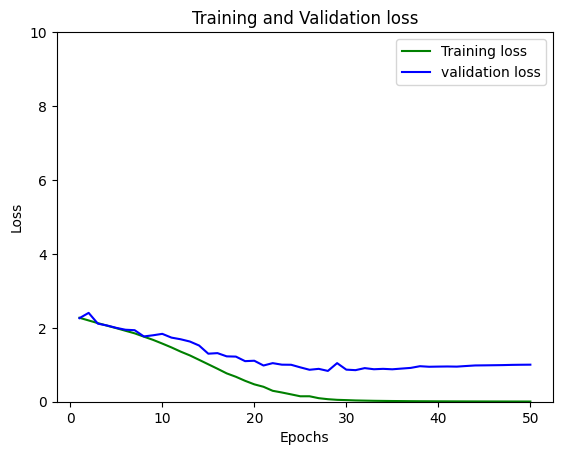

In [23]:
plot_model_loss(history)

### BETA

In [27]:
model = models.Sequential(name="BetaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(layers.Activation(activation='relu'))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))


model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "BetaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0 

In [28]:
start_time = time.time()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy']) # adam optimizer
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3) # callback za early stopping

epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[callback])
end_time = time.time()

Epoch 1/50
280/280 [==============================] - 4s 13ms/step - loss: 4.8630 - accuracy: 0.2510 - val_loss: 11.7837 - val_accuracy: 0.1187
Epoch 2/50
280/280 [==============================] - 4s 13ms/step - loss: 1.8692 - accuracy: 0.3875 - val_loss: 8.8256 - val_accuracy: 0.2112
Epoch 3/50
280/280 [==============================] - 3s 12ms/step - loss: 1.5431 - accuracy: 0.5008 - val_loss: 3.9887 - val_accuracy: 0.3353
Epoch 4/50
280/280 [==============================] - 4s 13ms/step - loss: 1.2377 - accuracy: 0.5994 - val_loss: 6.3917 - val_accuracy: 0.3496
Epoch 5/50
280/280 [==============================] - 4s 13ms/step - loss: 1.1812 - accuracy: 0.6386 - val_loss: 5.8023 - val_accuracy: 0.3290
Epoch 6/50
280/280 [==============================] - 4s 13ms/step - loss: 0.8610 - accuracy: 0.7385 - val_loss: 3.7349 - val_accuracy: 0.4835
Epoch 7/50
280/280 [==============================] - 4s 13ms/step - loss: 0.7588 - accuracy: 0.7853 - val_loss: 2.8243 - val_accuracy: 0.522

1718032023.8335612

In [29]:
print_training_results(history, start_time, end_time)

Training duration: 59.2802 seconds
Final training accuracy: 0.9845
Final validation accuracy: 0.8031
Final training loss: 0.0558
Final validation loss: 1.8133


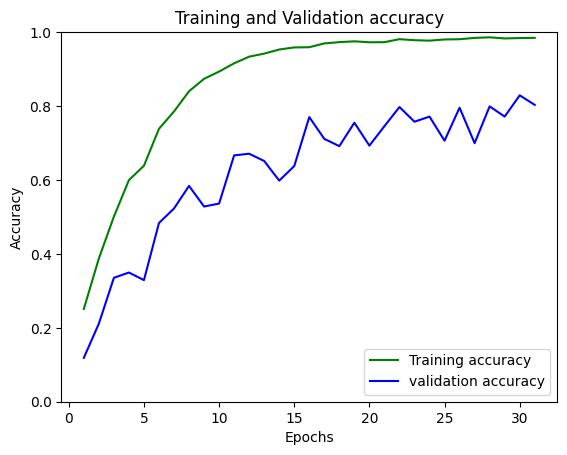

In [30]:
plot_model_accuracy(history)

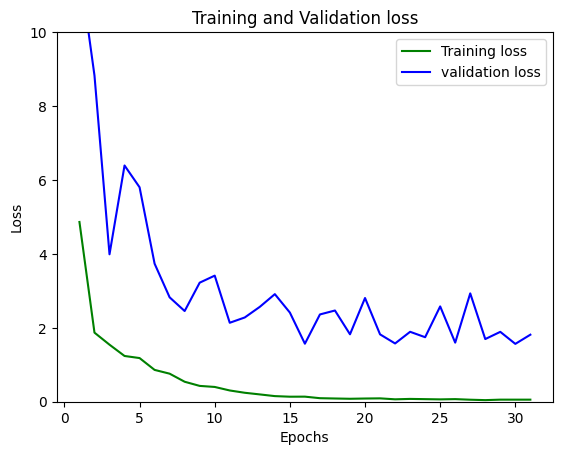

In [31]:
plot_model_loss(history)

### GAMA

In [32]:
model = models.Sequential(name="GamaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))


model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "GamaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                         

In [33]:
start_time = time.time()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

epochs = 100
batch_size = 32
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2, 
                    callbacks=[callback])
end_time = time.time()

Epoch 1/100
280/280 [==============================] - 4s 12ms/step - loss: 4.8955 - accuracy: 0.1334 - val_loss: 3.6076 - val_accuracy: 0.1098
Epoch 2/100
280/280 [==============================] - 3s 12ms/step - loss: 3.2867 - accuracy: 0.1496 - val_loss: 3.1076 - val_accuracy: 0.1272
Epoch 3/100
280/280 [==============================] - 3s 12ms/step - loss: 2.9573 - accuracy: 0.1579 - val_loss: 2.7782 - val_accuracy: 0.1781
Epoch 4/100
280/280 [==============================] - 3s 12ms/step - loss: 2.7157 - accuracy: 0.1770 - val_loss: 2.5709 - val_accuracy: 0.1920
Epoch 5/100
280/280 [==============================] - 3s 12ms/step - loss: 2.6128 - accuracy: 0.1703 - val_loss: 2.5588 - val_accuracy: 0.1844
Epoch 6/100
280/280 [==============================] - 3s 12ms/step - loss: 2.4929 - accuracy: 0.1894 - val_loss: 2.8024 - val_accuracy: 0.2018
Epoch 7/100
280/280 [==============================] - 3s 12ms/step - loss: 2.3221 - accuracy: 0.2506 - val_loss: 2.3911 - val_accuracy:

In [34]:
print_training_results(history, start_time, end_time)

Training duration: 140.5276 seconds
Final training accuracy: 0.8993
Final validation accuracy: 0.8772
Final training loss: 1.3749
Final validation loss: 1.475


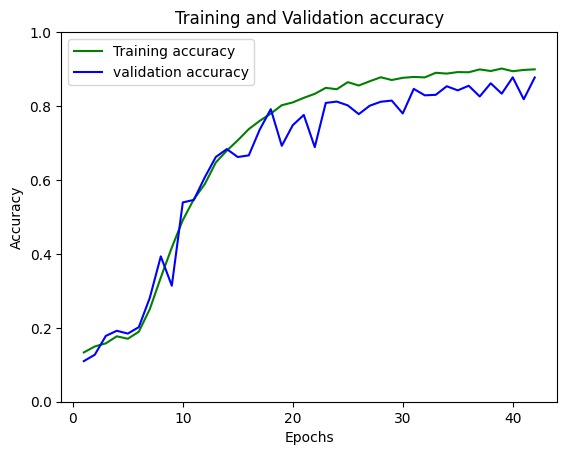

In [35]:
plot_model_accuracy(history)

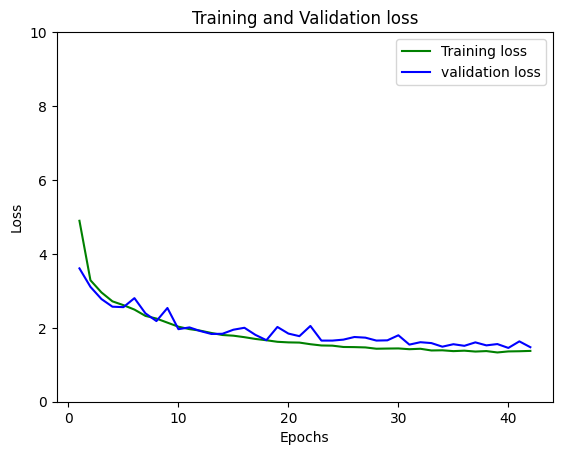

In [36]:
plot_model_loss(history)

### DELTA

In [37]:
# DATA AGUMENTATION PARAMETRI
datagen = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2
)
datagen.fit(X_train)

In [38]:
model = models.Sequential(name="DeltaModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "DeltaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        1

In [39]:
end_time = time.time()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = callbacks.ModelCheckpoint('SHNL_model64.h5', monitor='val_loss', save_best_only=True)

epochs = 100
batch_size = 64

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler])
end_time = time.time()

Epoch 1/100
175/175 [==============================] - 6s 28ms/step - loss: 5.1032 - accuracy: 0.1294 - val_loss: 3.7781 - val_accuracy: 0.1057 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 5s 27ms/step - loss: 3.4441 - accuracy: 0.1476 - val_loss: 3.2684 - val_accuracy: 0.1521 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 5s 27ms/step - loss: 3.0764 - accuracy: 0.1466 - val_loss: 2.9484 - val_accuracy: 0.1425 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 5s 26ms/step - loss: 2.8276 - accuracy: 0.1569 - val_loss: 2.7785 - val_accuracy: 0.1425 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 5s 27ms/step - loss: 2.6911 - accuracy: 0.1555 - val_loss: 2.5953 - val_accuracy: 0.1807 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 5s 27ms/step - loss: 2.5794 - accuracy: 0.1653 - val_loss: 2.5505 - val_accuracy: 0.1721 - lr: 0.0010
Epoch 7/100
175/175 [==============================] - 5s 

In [40]:
print_training_results(history, start_time, end_time)

Training duration: 622.1344 seconds
Final training accuracy: 0.8704
Final validation accuracy: 0.8936
Final training loss: 0.6625
Final validation loss: 0.611


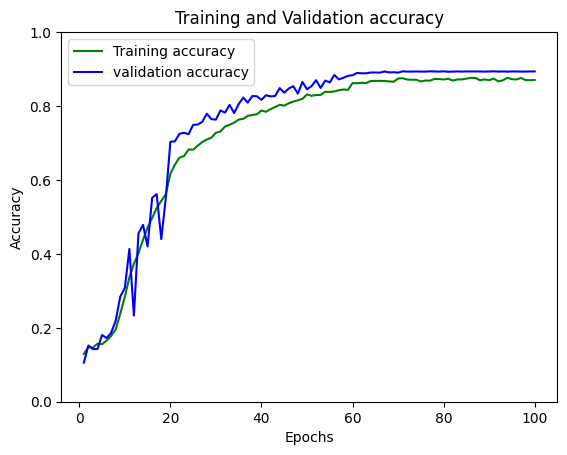

In [41]:
plot_model_accuracy(history)

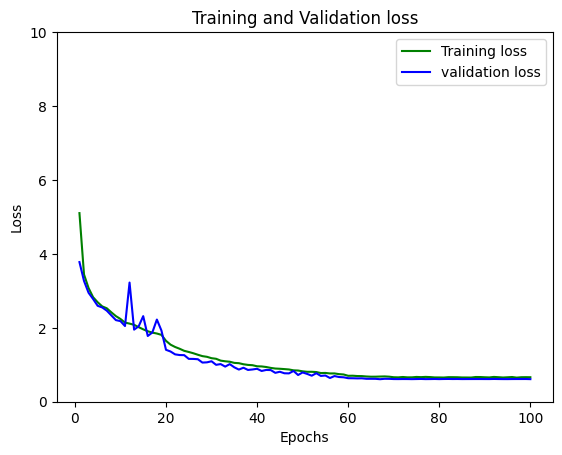

In [42]:
plot_model_loss(history)

### EPSILON

In [20]:
model = models.Sequential(name="EpsilonModel")
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same',  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='leaky_relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.26))


model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.26))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "EpsilonModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)       

In [19]:
start_time = time.time()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = callbacks.ModelCheckpoint('SHNL_model64.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32,
                     epochs=150,
                     validation_data=(X_val, y_val),
                     callbacks=[lr_scheduler, checkpoint, early_stopping])
end_time = time.time()

Epoch 1/150


2024-06-10 18:30:05.067160: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700


350/350 [==============================] - 7s 16ms/step - loss: 5.1262 - accuracy: 0.1210 - val_loss: 3.8782 - val_accuracy: 0.0921 - lr: 0.0010
Epoch 2/150
350/350 [==============================] - 5s 14ms/step - loss: 3.2539 - accuracy: 0.1569 - val_loss: 2.8700 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 3/150
350/350 [==============================] - 5s 14ms/step - loss: 2.5754 - accuracy: 0.2163 - val_loss: 2.4640 - val_accuracy: 0.2336 - lr: 0.0010
Epoch 4/150
350/350 [==============================] - 5s 14ms/step - loss: 2.3837 - accuracy: 0.2416 - val_loss: 2.2998 - val_accuracy: 0.2589 - lr: 0.0010
Epoch 5/150
350/350 [==============================] - 5s 14ms/step - loss: 2.2700 - accuracy: 0.2675 - val_loss: 2.2250 - val_accuracy: 0.2611 - lr: 0.0010
Epoch 6/150
350/350 [==============================] - 5s 14ms/step - loss: 2.2096 - accuracy: 0.2800 - val_loss: 2.3753 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 7/150
350/350 [==============================] - 5s 15ms/step - 

In [21]:
print_training_results(history, start_time, end_time)

Training duration: 543.7803 seconds
Final training accuracy: 0.9898
Final validation accuracy: 0.9686
Final training loss: 0.2375
Final validation loss: 0.3148


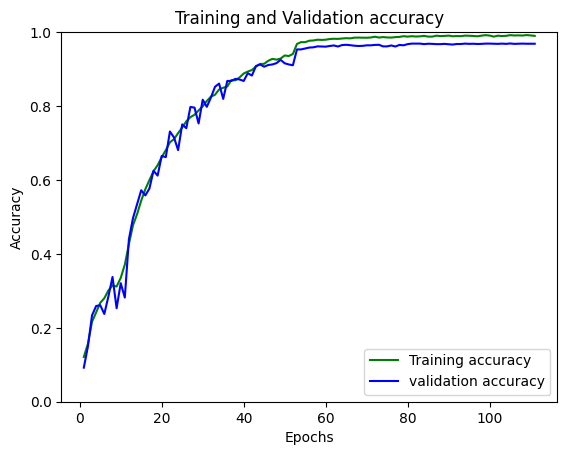

In [22]:
plot_model_accuracy(history)

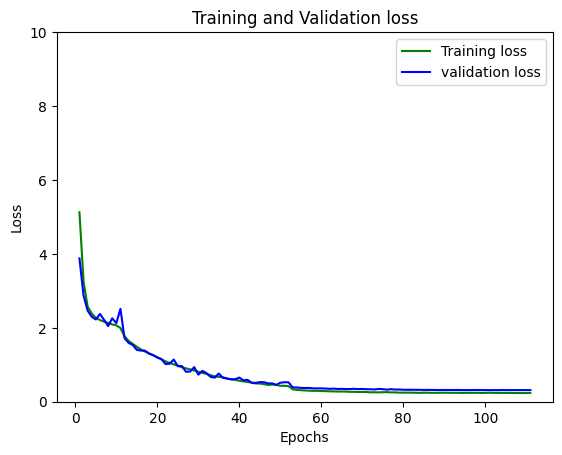

In [23]:
plot_model_loss(history)

88/88 [==============================] - 1s 6ms/step - loss: 0.3146 - accuracy: 0.9686
Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       290
           1       0.98      0.98      0.98       274
           2       0.98      0.97      0.97       297
           3       0.98      0.97      0.97       258
           4       0.95      0.95      0.95       296
           5       0.96      0.98      0.97       261
           6       0.97      0.97      0.97       301
           7       0.98      0.98      0.98       286
           8       0.94      0.96      0.95       258
           9       0.97      0.95      0.96       279

    accuracy                           0.97      2800
   macro avg       0.97      0.97      0.97      2800
weighted avg       0.97      0.97      0.97      2800



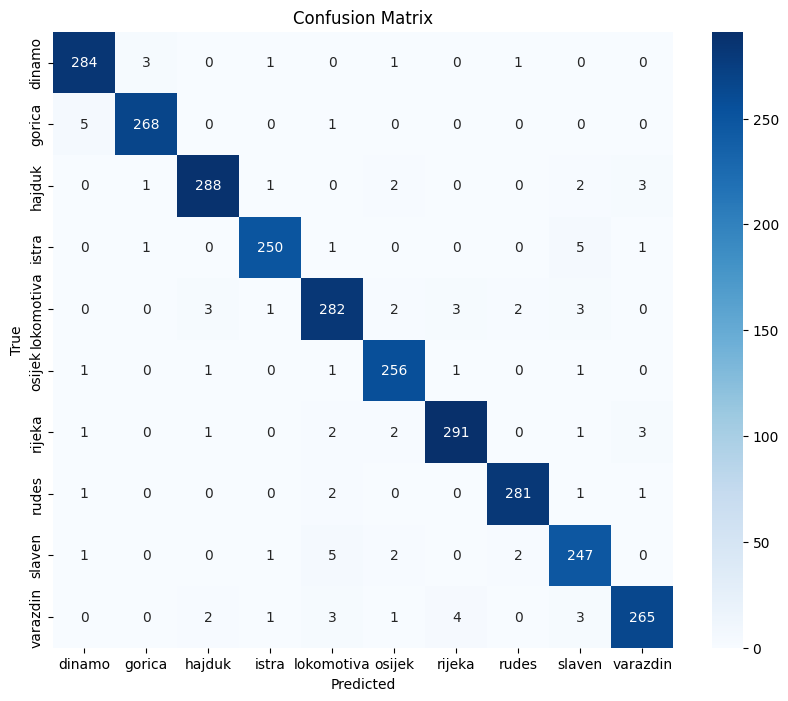

In [24]:
conf_matrix = generate_report_and_matrix('SHNL_model64.h5', X_val, y_val)
plot_confusion_matrix(conf_matrix, club_names=klubovi)

### TRANSFER LEARNING

In [53]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# MobileNetV2 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Dodaj slojeve putem x varijable
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Dropout 50%
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))(x)

# FC sloj
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze baznog modela, 30 zadnjih slojeva
for layer in base_model.layers[-30:]:
    layer.trainable = True


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [54]:
start_time = time.time()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = callbacks.ModelCheckpoint('TL_SHNL_model64.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=200, validation_data=(X_val, y_val),
                     callbacks=[lr_scheduler, checkpoint, early_stopping])
end_time = time.time()

Epoch 1/200
350/350 [==============================] - 13s 32ms/step - loss: 5.0645 - accuracy: 0.5363 - val_loss: 2.8124 - val_accuracy: 0.0964 - lr: 0.0010
Epoch 2/200
350/350 [==============================] - 11s 31ms/step - loss: 0.9588 - accuracy: 0.7920 - val_loss: 2.6717 - val_accuracy: 0.1321 - lr: 0.0010
Epoch 3/200
350/350 [==============================] - 11s 31ms/step - loss: 0.6353 - accuracy: 0.8628 - val_loss: 1.5497 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 4/200
350/350 [==============================] - 11s 30ms/step - loss: 0.5292 - accuracy: 0.8954 - val_loss: 0.9619 - val_accuracy: 0.7696 - lr: 0.0010
Epoch 5/200
350/350 [==============================] - 10s 29ms/step - loss: 0.3842 - accuracy: 0.9295 - val_loss: 1.6978 - val_accuracy: 0.6632 - lr: 0.0010
Epoch 6/200
350/350 [==============================] - 10s 29ms/step - loss: 0.3197 - accuracy: 0.9444 - val_loss: 1.9289 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 7/200
350/350 [==============================]

In [55]:
print_training_results(history, start_time, end_time)

Training duration: 234.3673 seconds
Final training accuracy: 0.9997
Final validation accuracy: 0.9825
Final training loss: 0.0125
Final validation loss: 0.0742


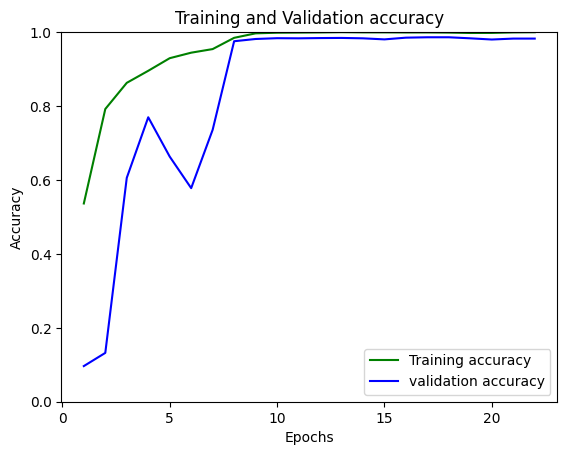

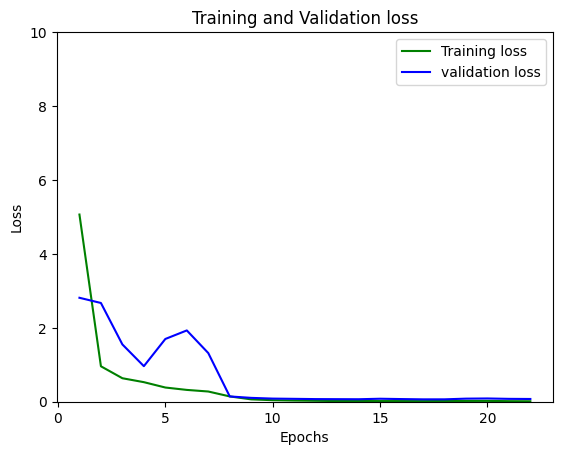

88/88 [==============================] - 1s 11ms/step - loss: 0.0640 - accuracy: 0.9861
Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       290
           1       0.99      0.99      0.99       274
           2       0.99      0.98      0.98       297
           3       0.98      0.99      0.99       258
           4       0.98      0.97      0.98       296
           5       0.99      0.98      0.99       261
           6       0.98      0.99      0.99       301
           7       1.00      0.98      0.99       286
           8       0.97      0.98      0.98       258
           9       0.99      1.00      0.99       279

    accuracy                           0.99      2800
   macro avg       0.99      0.99      0.99      2800
weighted avg       0.99      0.99      0.99      2800



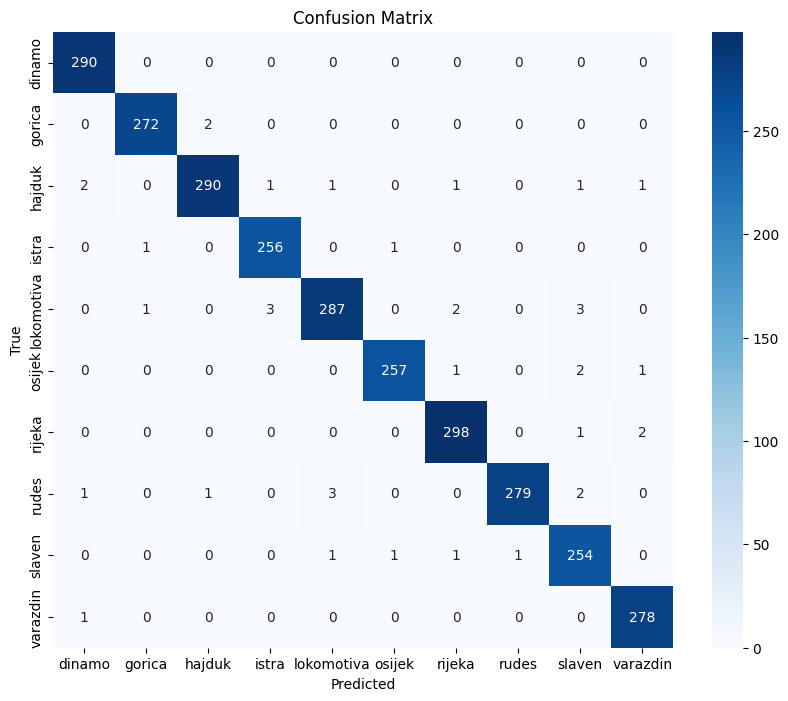

In [58]:
plot_model_accuracy(history)
plot_model_loss(history)
conf_matrix = generate_report_and_matrix('TL_SHNL_model64.h5', X_val, y_val)
plot_confusion_matrix(conf_matrix, club_names=klubovi)

## TESTIRANJE NAJBOLJIH MODELA

### PRIPREMA PODATAKA

In [25]:
# test data
data_dir = 'test_64'
data_dir = pathlib.Path(data_dir)

# DICT SA KLUBOVIMA I LABELAMA

test_klubovi_dict = {
    'dinamo': {'images': list(data_dir.glob('dinamo/*')), 'label': 0},
    'gorica': {'images': list(data_dir.glob('gorica/*')), 'label': 1},
    'hajduk': {'images': list(data_dir.glob('hajduk/*')), 'label': 2},
    'istra': {'images': list(data_dir.glob('istra/*')), 'label': 3},
    'lokomotiva': {'images': list(data_dir.glob('lokomotiva/*')), 'label': 4},
    'osijek': {'images': list(data_dir.glob('osijek/*')), 'label': 5},
    'rijeka': {'images': list(data_dir.glob('rijeka/*')), 'label': 6},
    'rudes': {'images': list(data_dir.glob('rudes/*')), 'label': 7},
    'slaven': {'images': list(data_dir.glob('slaven/*')), 'label': 8},
    'varazdin': {'images': list(data_dir.glob('varazdin/*')), 'label': 9},
}

br_slicica = len(list(data_dir.glob('*/*.jpg')))
klubovi = [str(klub).split('/')[-1] for klub in test_klubovi_dict.keys()]
print(f'{klubovi},\n Ukupni broj slicica: {br_slicica}')

club_names = list(test_klubovi_dict.keys())

['dinamo', 'gorica', 'hajduk', 'istra', 'lokomotiva', 'osijek', 'rijeka', 'rudes', 'slaven', 'varazdin'],
 Ukupni broj slicica: 1400


In [26]:
# podijeli u X_test i y_test
X_test, y_test = [], []

for klub_name, klub_info in test_klubovi_dict.items():
    for image in klub_info['images']:
        img = cv2.imread(str(image))
        if img is not None:
            X_test.append(img)
            y_test.append(test_klubovi_dict[klub_name]['label'])
        else:
            print(f"Image at {image} could not be read.")

# Convert to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize the test data
X_test = X_test / 255

### 1. SHNL_model64.h5 - BEZ KORIŠTENJA TRANSFER LEARNINGA

44/44 [==============================] - 0s 4ms/step - loss: 1.6241 - accuracy: 0.7279
Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       140
           1       0.86      0.66      0.75       140
           2       0.99      0.57      0.72       140
           3       0.97      0.93      0.95       140
           4       0.43      0.89      0.58       140
           5       0.97      0.82      0.89       140
           6       0.89      0.79      0.83       140
           7       0.79      0.76      0.78       140
           8       0.48      0.86      0.61       140
           9       0.85      0.29      0.43       140

    accuracy                           0.73      1400
   macro avg       0.81      0.73      0.73      1400
weighted avg       0.81      0.73      0.73      1400



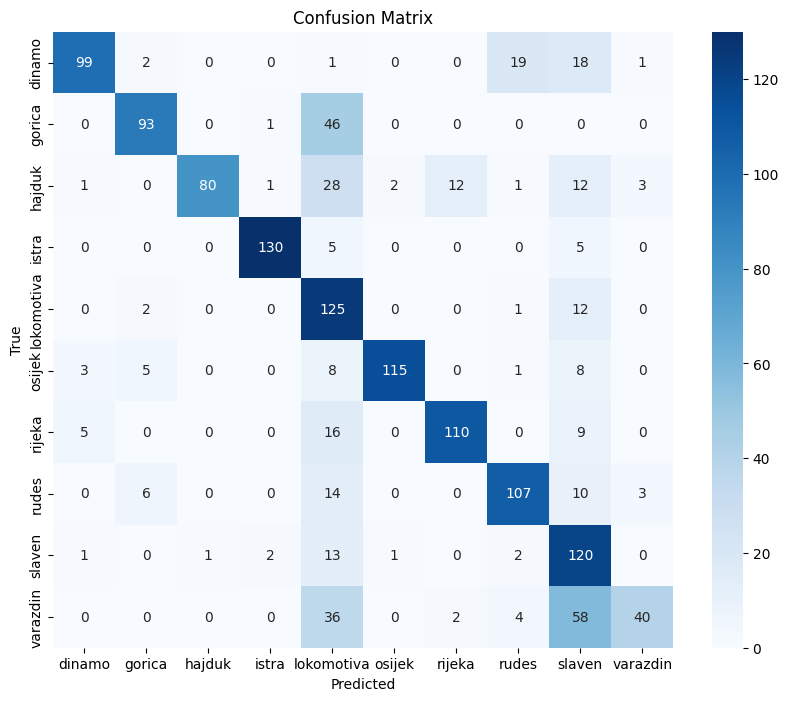

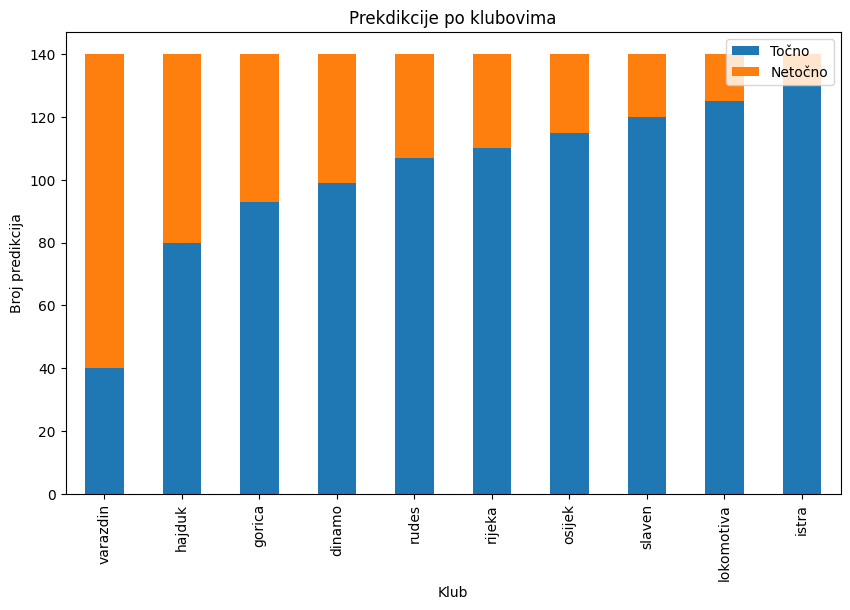

In [27]:
best_model = models.load_model('SHNL_model64.h5')
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = generate_report_and_matrix('SHNL_model64.h5', X_test, y_test)

plot_confusion_matrix(conf_matrix, club_names)
plot_predictions(y_test, y_pred_classes, club_names)

### 2. TL_SHNL_model64.h5 - KORIŠTENJE TRANSFER LEARNINGA

44/44 [==============================] - 1s 12ms/step - loss: 1.1171 - accuracy: 0.7507
Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.69      0.79       140
           1       0.91      0.75      0.82       140
           2       0.81      0.77      0.79       140
           3       0.85      0.96      0.91       140
           4       0.60      0.78      0.68       140
           5       0.90      0.80      0.85       140
           6       0.93      0.66      0.77       140
           7       0.72      0.76      0.74       140
           8       0.50      0.86      0.63       140
           9       0.70      0.47      0.56       140

    accuracy                           0.75      1400
   macro avg       0.79      0.75      0.75      1400
weighted avg       0.79      0.75      0.75      1400



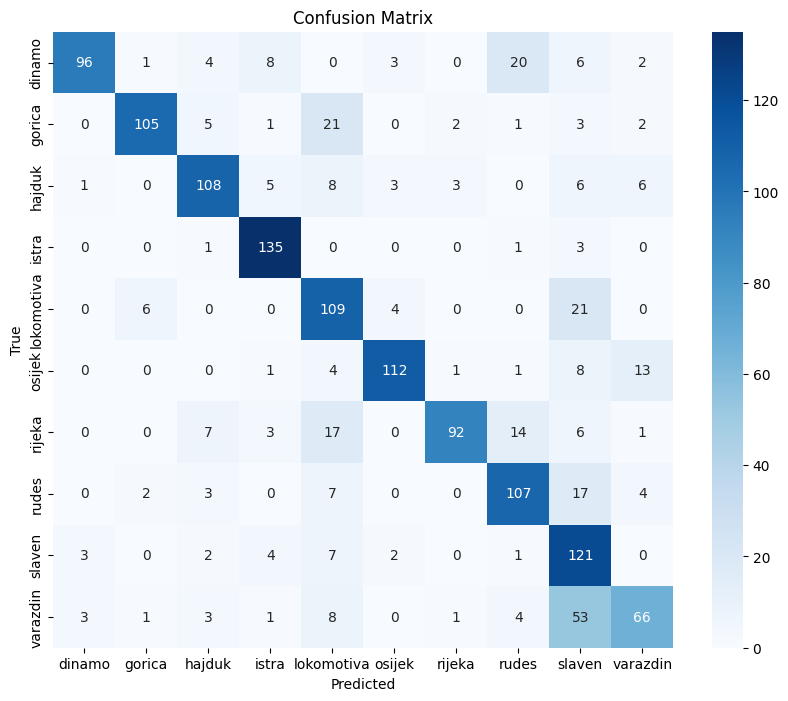

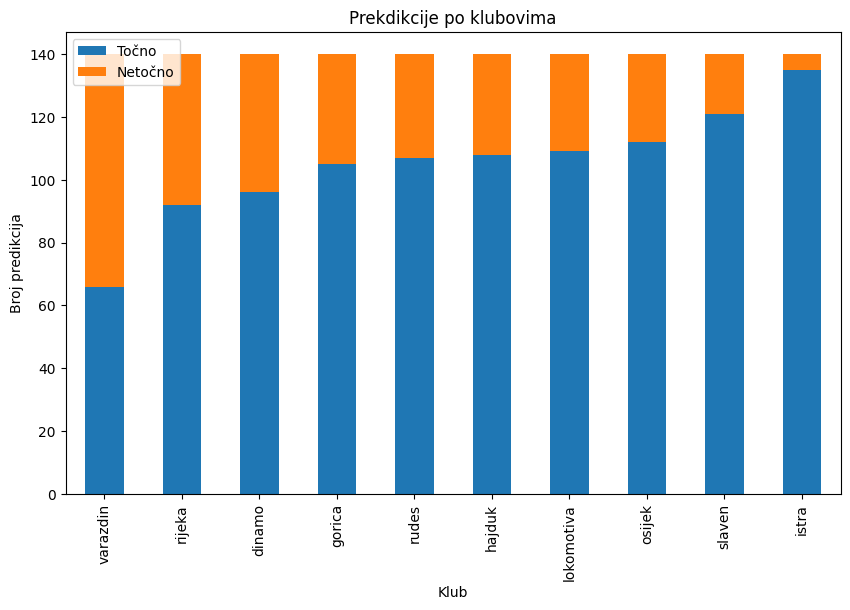

In [62]:
best_model = models.load_model('TL_SHNL_model64.h5')
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

club_names = list(test_klubovi_dict.keys())

conf_matrix = generate_report_and_matrix('TL_SHNL_model64.h5', X_test, y_test)

plot_confusion_matrix(conf_matrix, club_names)
plot_predictions(y_test, y_pred_classes, club_names)